# Execution of Cox model - 1st article

In this notebook, we test the Cox model for the data from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163.

In [15]:
import pandas as pd
import numpy as np
from survivalAnalysis.CoxModel import CoxModel
from survivalAnalysis.LogRankTest import LogRankTest
from models.Classifier import Classifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

## 1. Reading and preprocessing

We read the ```data/Supplemental-table1.xlsx``` file, and we drop the non-naive patients from the dataframe.

In [16]:
df = pd.read_excel('data/Supplemental-table1.xlsx')
df = df.loc[df["Cohort"] == "Naive"]
df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


## 2. Determine the risk class for each using Cox regression and survival curves

With the ```CoxModel``` class implementing a Cox Regression, we can determine the risk class for each sample : high (class 1) or low (class 0). Because we have few data, we use a **leave one out cross validation**, which consists in fitting the model with all the dataset except 1 sample, then we predict the risk class for the test sample.

In [17]:
coxmodel = CoxModel()
log_rank_tester = LogRankTest()

### TTP (Time To Progression) event
Here, the event is the disease has progressed. So we measure the risk of the disease to progress.

#### Finding risk classes

In [18]:
# Preprocessing for the label data
X_ttp = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_ttp = np.array(list((df[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

# Finding the risk classes
risk_classes_ttp = coxmodel.leave_one_out_cross_validation(X_ttp,y_ttp)
risk_classes_ttp

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
       0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

#### Determining the survival curves
With the Cox model, we have the survival probability for each sample along time. So we compute the mean survival curve from these curves.

In [19]:
# Split the data in high risk group and low risk group
high_risk_ttp = X_ttp[np.where(risk_classes_ttp==1)]
low_risk_ttp = X_ttp[np.where(risk_classes_ttp==0)]
print(f"High risk samples : {high_risk_ttp.shape[0]}")
print(f"Low risk samples : {low_risk_ttp.shape[0]}")

# Compute the mean survival curves for each group
high_risk_event_times_ttp, high_risk_survival_curve_ttp = coxmodel.predict_mean_survival_curve(high_risk_ttp)
low_risk_event_times_ttp, low_risk_survival_curve_ttp = coxmodel.predict_mean_survival_curve(low_risk_ttp)

# Compute the concordance index
c_index_ttp = coxmodel.find_concordance_index(X_ttp, y_ttp)

# Compute the p value of the log rank test
# Select Progression_1 and Time to progression for high class and low class
high_risk_ttp_log_rank_test_values = df.loc[:,["Progression_1","Time to progression (days)"]].to_numpy()[np.where(risk_classes_ttp == 1)]
low_risk_ttp_log_rank_test_values = df.loc[:,["Progression_1","Time to progression (days)"]].to_numpy()[np.where(risk_classes_ttp == 0)]
high_risk_ttp_status, high_risk_ttp_time = high_risk_ttp_log_rank_test_values[:,0],high_risk_ttp_log_rank_test_values[:,1]
low_risk_ttp_status, low_risk_ttp_time = low_risk_ttp_log_rank_test_values[:,0],low_risk_ttp_log_rank_test_values[:,1]
p_value_ttp = log_rank_tester.make_test(low_risk_ttp_time,low_risk_ttp_status,high_risk_ttp_time,high_risk_ttp_status)

High risk samples : 42
Low risk samples : 40


### OS (Overall survival) event
Here, the event is the patient has died. So we measure the risk of death.

##### Finding the risk classes

In [20]:
# Preprocessing for the label data
X_os = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_os = np.array(list((df[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

# Finding the risk classes
risk_classes_os = coxmodel.leave_one_out_cross_validation(X_os,y_os)
risk_classes_os

array([0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.])

##### Determining the survival curves

In [21]:
# Split the data in high risk group and low risk group
high_risk_os = X_os[np.where(risk_classes_os==1)]
low_risk_os = X_os[np.where(risk_classes_os==0)]
print(f"High risk samples : {high_risk_os.shape[0]}")
print(f"Low risk samples : {low_risk_os.shape[0]}")

# Compute the mean survival curves for each group
high_risk_event_times_os, high_risk_survival_curve_os = coxmodel.predict_mean_survival_curve(high_risk_os)
low_risk_event_times_os, low_risk_survival_curve_os = coxmodel.predict_mean_survival_curve(low_risk_os)

# Compute the concordance index
c_index_os = coxmodel.find_concordance_index(X_os, y_os)

# Compute the p value of the log rank test
# Select Progression_1 and Time to progression for high class and low class
high_risk_os_log_rank_test_values = df.loc[:,["Alive_0","Overall survival (days)"]].to_numpy()[np.where(risk_classes_os == 1)]
low_risk_os_log_rank_test_values = df.loc[:,["Alive_0","Overall survival (days)"]].to_numpy()[np.where(risk_classes_os == 0)]
high_risk_os_status, high_risk_os_time = high_risk_os_log_rank_test_values[:,0],high_risk_os_log_rank_test_values[:,1]
low_risk_os_status, low_risk_os_time = low_risk_os_log_rank_test_values[:,0],low_risk_os_log_rank_test_values[:,1]
p_value_os = log_rank_tester.make_test(low_risk_os_time,low_risk_os_status,high_risk_os_time,high_risk_os_status)

High risk samples : 42
Low risk samples : 40


## 3. Plot the survival curves
Now, we want to plot the survival curves for each class (high and low). Ideally, the curves should be very different.

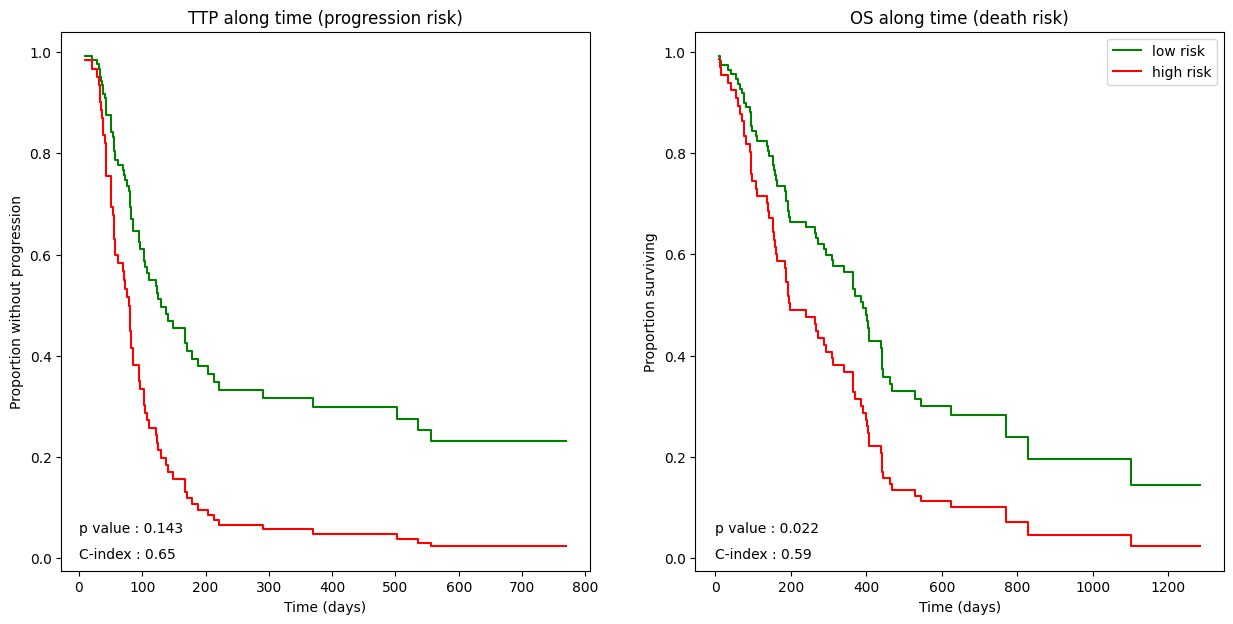

In [22]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

# TTP : 
ax[0].step(low_risk_event_times_ttp, low_risk_survival_curve_ttp, where='post',color='green',label='low risk')
ax[0].step(high_risk_event_times_ttp, high_risk_survival_curve_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Proportion without progression')
ax[0].set_title('TTP along time (progression risk)')
ax[0].text(0,0,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

# OS : 
ax[1].step(low_risk_event_times_os, low_risk_survival_curve_os, where='post',color='green',label='low risk')
ax[1].step(high_risk_event_times_os, high_risk_survival_curve_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Proportion surviving')
ax[1].set_title('OS along time (death risk)')
ax[1].text(0,0,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('survival-curves.png')

## 4. Classify patients between responders and non responders

### Select useful columns and binarize Clinical benefit column
The 2 possible classes are DCB (responders) and NCB (non responders). Let's binarize this column (1 for DCB, 0 for NCB).

In [23]:
df_classification = df.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression","Clinical benefit","Progression_1","Time to progression (days)","Alive_0","Overall survival (days)"]]
df_classification.loc[df_classification["Clinical benefit"]=="DCB","Clinical benefit"] = 1
df_classification.loc[df_classification["Clinical benefit"] == "NCB","Clinical benefit"] = 0
df_classification

,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Clinical benefit,Progression_1,Time to progression (days),Alive_0,Overall survival (days)
0,0.351869,11.095310,23.0729,4.1689,55.51575,0,1,179,1,391
1,0.071464,3.876336,5.4552,0.7910,9.32352,0,1,148,1,544
2,0.040394,2.415688,4.1274,4.0377,50.12008,0,1,79,1,408
3,0.052774,6.235845,11.4871,0.6006,1.58550,0,0,11,1,11
4,0.009323,4.606660,7.1503,1.8234,38.42695,0,1,80,1,385
...,...,...,...,...,...,...,...,...,...,...
92,0.695396,84.998501,96.4079,8.4768,86.62561,1,0,401,1,401
94,0.818233,2.247151,2.7416,11.2704,47.97376,0,0,96,1,96
95,0.018982,3.848247,5.8036,8.7136,5.13403,0,1,69,1,441
96,0.000000,5.617878,7.7940,0.0688,0.51364,0,1,51,1,158


### Train and predict classes (on train set)

In [24]:
# Extract features and labels
X_train = df_classification.loc[:,["CD8+ T cell score","Exome mut per mb","Genome mut per mb","CD274 expression","M1M2 expression"]].to_numpy()
y_train = df_classification["Clinical benefit"].to_numpy().astype(int)

# Classify
clf = Classifier(LogisticRegression())
clf.train(X_train, y_train)
y_pred = clf.predict(X_train)

# Evaluate the model :
accuracy, precision, recall, f1 = clf.evaluate_model(y_train, y_pred)
print(f"Accuracy : {accuracy}")
print(f"Precision : {precision}")
print(f"Recall : {recall}")
print(f"F1 : {f1}")

Accuracy : 0.8048780487804879
Precision : 0.5555555555555556
Recall : 0.29411764705882354
F1 : 0.3846153846153846


### Determine the survival curves for each class

#### TTP

In [25]:
# Split dcb and ncb group
dcb_ttp = X_ttp[np.where(y_pred==1)]
ncb_ttp = X_ttp[np.where(y_pred==0)]

# Find survival curve
dcb_event_times_ttp, dcb_survival_curve_ttp = coxmodel.predict_mean_survival_curve(dcb_ttp)
ncb_event_times_ttp, ncb_survival_curve_ttp = coxmodel.predict_mean_survival_curve(ncb_ttp)

# Compute the C-index
c_index_dcb_ncb_ttp = coxmodel.find_concordance_index(X_ttp, y_ttp)

# Compute the p-value
dcb_ttp_log_rank_test_values = df.loc[:,["Progression_1","Time to progression (days)"]].to_numpy()[np.where(y_pred == 1)]
ncb_ttp_log_rank_test_values = df.loc[:,["Progression_1","Time to progression (days)"]].to_numpy()[np.where(y_pred == 0)]
dcb_ttp_status, dcb_ttp_time = dcb_ttp_log_rank_test_values[:,0],dcb_ttp_log_rank_test_values[:,1]
ncb_ttp_status, ncb_ttp_time = ncb_ttp_log_rank_test_values[:,0],ncb_ttp_log_rank_test_values[:,1]
p_value_dcb_ncb_ttp = log_rank_tester.make_test(dcb_ttp_time, dcb_ttp_status, ncb_ttp_time, ncb_ttp_status)

#### OS

In [26]:
# Split dcb and ncb group
dcb_os = X_os[np.where(y_pred==1)]
ncb_os = X_os[np.where(y_pred==0)]

# Find survival curve
dcb_event_times_os, dcb_survival_curve_os = coxmodel.predict_mean_survival_curve(dcb_os)
ncb_event_times_os, ncb_survival_curve_os = coxmodel.predict_mean_survival_curve(ncb_os)

# Compute the C-index
c_index_dcb_ncb_os = coxmodel.find_concordance_index(X_os, y_os)

# Compute the p-value
dcb_os_log_rank_test_values = df.loc[:,["Alive_0","Overall survival (days)"]].to_numpy()[np.where(y_pred == 1)]
ncb_os_log_rank_test_values = df.loc[:,["Alive_0","Overall survival (days)"]].to_numpy()[np.where(y_pred == 0)]
dcb_os_status, dcb_os_time = dcb_os_log_rank_test_values[:,0],dcb_os_log_rank_test_values[:,1]
ncb_os_status, ncb_os_time = ncb_os_log_rank_test_values[:,0],ncb_os_log_rank_test_values[:,1]
p_value_dcb_ncb_os = log_rank_tester.make_test(dcb_os_time, dcb_os_status, ncb_os_time, ncb_os_status)

#### Make the plot

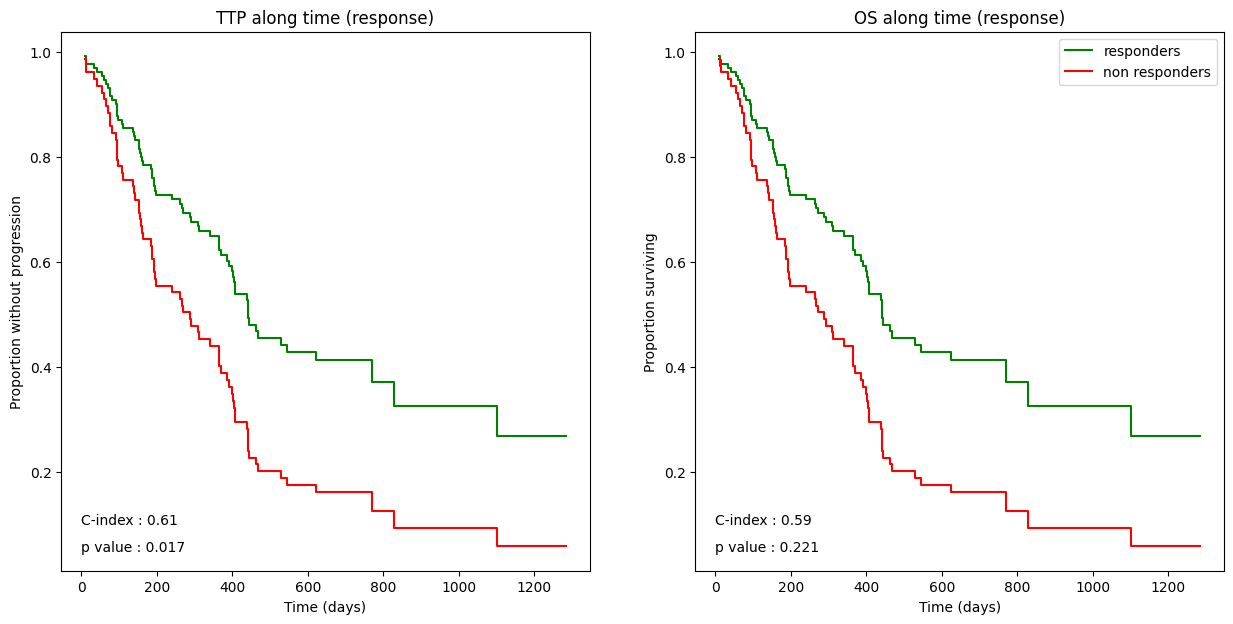

In [27]:
fig, ax = plt.subplots(1,2,figsize=(15,7))

# TTP : 
ax[0].step(dcb_event_times_ttp, dcb_survival_curve_ttp, where='post',color='green',label='responders')
ax[0].step(ncb_event_times_ttp, ncb_survival_curve_ttp, where='post',color='red',label='non responders')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('Proportion without progression')
ax[0].set_title('TTP along time (response)')
ax[0].text(0,0.1,f'C-index : {c_index_dcb_ncb_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_dcb_ncb_ttp}')

# OS : 
ax[1].step(dcb_event_times_os, dcb_survival_curve_os, where='post',color='green',label='responders')
ax[1].step(ncb_event_times_os, ncb_survival_curve_os, where='post',color='red',label='non responders')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Proportion surviving')
ax[1].set_title('OS along time (response)')
ax[1].text(0,0.1,f'C-index : {c_index_dcb_ncb_os}')
ax[1].text(0,0.05,f'p value : {p_value_dcb_ncb_os}')

plt.legend()
plt.savefig('survival-curves-responders.png')